<a href="https://www.kaggle.com/code/aiotengineer/model-aar-lstm-mt-2025?scriptVersionId=250057560" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  
from sklearn import metrics
import random
from random import randint
import time
import os

In [3]:
SEED = 36  

os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED) 
# Output classes to learn how to classify
LABELS = [    
    "DIEU_HANH",
    "CHAY_BO",
    "NHAY_CACH_QUANG",
    "BAT_TACH_CHUM",
    "BAT_NANG_GOI",
    "BAT_CAT_KEO",
    "BAT_DA_CHAN"
] 
DATASET_PATH = "/kaggle/input/data-3-0/"

X_train_path = DATASET_PATH + "x_tr.txt"
X_test_path = DATASET_PATH + "x_ts.txt"

y_train_path = DATASET_PATH + "y_trr.txt"
y_test_path = DATASET_PATH + "y_tss.txt"

n_steps = 32 # 32 timesteps per series
n_categories = len(LABELS)
print(n_categories)

7


# **Load the Input:**

In [4]:
#load the input

def load_X(X_path):
    file = open(X_path, 'r')
    X_ = np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]],
        dtype=np.float32
    )
    file.close()
    blocks = int(len(X_) / n_steps)

    X_ = np.array(np.split(X_,blocks))

    return X_

# Load the networks outputs

def load_y(y_path):
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()

    # for 0-based indexing
    return y_ -1

X_train = load_X(X_train_path)
X_test = load_X(X_test_path)
#print X_test


y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


# **SET THE PARAMETER:**

In [5]:
training_data_count = len(X_train)
test_data_count = len(X_test)
n_input = len(X_train[0][0])

n_hidden = 64
n_classes = 7

# Learning rate parameters
decaying_learning_rate = True
learning_rate = 0.0025
init_learning_rate = 0.005
decay_rate = 0.96
decay_steps = 9000

lambda_loss_amount = 0.0015

training_iters = training_data_count * 300
batch_size = 128
display_iter = batch_size * 8

print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_train.shape, y_test.shape, np.mean(X_test), np.std(X_test))


# Thêm n_steps (giả sử dựa trên shape của X_train)
n_steps = X_train.shape[1]


(X shape, y shape, every X's mean, every X's standard deviation)
(7786, 32, 36) (1461, 1) 316.1445 176.19168

The dataset has not been preprocessed, is not normalised etc


# **Essential Function for building the network** 

In [6]:
#Utility Functions 


lstm_cell_1 = tf.keras.layers.LSTMCell(n_hidden)
lstm_cell_2 = tf.keras.layers.LSTMCell(n_hidden)
lstm_cell_3 = tf.keras.layers.LSTMCell(n_hidden)

def LSTM_RNN(_X, _weights, _biases):
    # Chuyển đổi shape từ [batch, steps, features] sang [steps, batch, features]
    _X = tf.transpose(_X, [1, 0, 2])
    _X = tf.reshape(_X, [-1, n_input])

    # ReLU activation cho hidden layer
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])

    # Chia dữ liệu thành list các tensors cho từng timestep
    _X = tf.split(_X, n_steps, axis=0)

    # Khởi tạo states
    batch_size_dynamic = tf.shape(_X[0])[0]
    state_1 = lstm_cell_1.get_initial_state(batch_size=batch_size_dynamic)
    state_2 = lstm_cell_2.get_initial_state(batch_size=batch_size_dynamic)
    state_3 = lstm_cell_3.get_initial_state(batch_size=batch_size_dynamic)
    # First LSTM layer
    outputs_1 = []
    for timestep in _X:
        output_1, state_1 = lstm_cell_1(timestep, states=state_1)
        outputs_1.append(output_1)
    
    # Lớp 2
    outputs_2 = []
    for output_1 in outputs_1:
        output_2, state_2 = lstm_cell_2(output_1, states=state_2)
        outputs_2.append(output_2)
    
    # Lớp 3
    outputs_3 = []
    for output_2 in outputs_2:
        output_3, state_3 = lstm_cell_3(output_2, states=state_3)
        outputs_3.append(output_3)

    # Output cuối
    lstm_last_output = outputs_3[-1]
    # Lấy output cuối cùng
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


    # Linear activation cho output layer
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']

def extract_batch_size(_train, _labels, _unsampled, batch_size):
    """
    Trích xuất một batch dữ liệu với kích thước batch_size
    """
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    batch_labels = np.empty((batch_size, 1))

    for i in range(batch_size):
        index = random.choice(_unsampled)
        batch_s[i] = _train[index]
        batch_labels[i] = _labels[index]
        _unsampled.remove(index)

    return batch_s, batch_labels, _unsampled

def one_hot(y_):
    """
    Chuyển đổi labels sang dạng one-hot encoding
    """
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]


I0000 00:00:1751641859.109292      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751641859.110052      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# **BUILD THE NETWORK:**

In [7]:
#build the network

weights = {
    'hidden': tf.Variable(tf.random.normal([n_input, n_hidden], seed=SEED)),
    'out': tf.Variable(tf.random.normal([n_hidden, n_classes], mean=1.0, seed=SEED + 1))
}
biases = {
    'hidden': tf.Variable(tf.random.normal([n_hidden], seed=SEED + 2)),
    'out': tf.Variable(tf.random.normal([n_classes], seed=SEED + 3))
}

# Định nghĩa model forward pass
@tf.function
def model_forward(x):
    return LSTM_RNN(x, weights, biases)

# Thiết lập optimizer
if decaying_learning_rate:
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=init_learning_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate,
        staircase=True
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
else:
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Training step function
@tf.function
def train_step(x_batch, y_batch):
    with tf.GradientTape() as tape:
        predictions = model_forward(x_batch)

        # Softmax cross entropy loss
        ce_loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=y_batch, logits=predictions)
        )

        # L2 regularization
        l2_loss = lambda_loss_amount * sum(
            tf.nn.l2_loss(tf_var) for tf_var in weights.values()
        )
        l2_loss += lambda_loss_amount * sum(
            tf.nn.l2_loss(tf_var) for tf_var in biases.values()
        )

        # Total loss
        total_loss = ce_loss + l2_loss

    # Gradient update
    trainable_vars = list(weights.values()) + list(biases.values())
    gradients = tape.gradient(total_loss, trainable_vars)
    optimizer.apply_gradients(zip(gradients, trainable_vars))

    # Accuracy computation
    correct_pred = tf.equal(tf.argmax(predictions, 1), tf.argmax(y_batch, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    return total_loss, accuracy

# Test step function
@tf.function
def test_step(x_batch, y_batch):
    predictions = model_forward(x_batch)
    correct_pred = tf.equal(tf.argmax(predictions, 1), tf.argmax(y_batch, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    return accuracy


In [8]:
# ===== PARAMETER COUNT CALCULATION =====
def count_lstm_parameters():
    """Tính số lượng tham số của LSTM model"""
    
    # Weight parameters
    total_weights = 0
    for key, weight in weights.items():
        params = tf.size(weight).numpy()
        total_weights += params
        print(f"  {key} weights: {weight.shape} = {params:,} parameters")
    
    # Bias parameters  
    total_biases = 0
    for key, bias in biases.items():
        params = tf.size(bias).numpy()
        total_biases += params
        print(f"  {key} biases: {bias.shape} = {params:,} parameters")
    
    # LSTM Cell parameters
    # Mỗi LSTM cell có 4 gates: input, forget, output, candidate
    # Mỗi gate có weights cho input và hidden state
    # = 4*[ (h+x)*h + h]
    lstm1_params = 4 * (n_hidden * n_hidden + n_hidden * n_hidden + n_hidden)  # W_h, W_x, bias
    lstm2_params = 4 * (n_hidden * n_hidden + n_hidden * n_hidden + n_hidden)  # Tương tự cho layer 2
    lstm3_params = 4 * (n_hidden * n_hidden + n_hidden * n_hidden + n_hidden)
    
    total_lstm_params = lstm1_params + lstm2_params + lstm3_params
    
    print(f"\nLSTM Cells Parameters:")
    print(f"  LSTM Cell 1: {lstm1_params:,} parameters")
    print(f"  LSTM Cell 2: {lstm2_params:,} parameters")
    print(f"  LSTM Cell 2: {lstm3_params:,} parameters")
    print(f"  Total LSTM parameters: {total_lstm_params:,}")
    
    total_parameters = total_weights + total_biases + total_lstm_params
    
    print(f"\n" + "="*50)
    print(f"MODEL PARAMETERS SUMMARY:")
    print(f"  Trainable weights: {total_weights:,}")
    print(f"  Trainable biases: {total_biases:,}")
    print(f"  LSTM internal parameters: {total_lstm_params:,}")
    print(f"  TOTAL PARAMETERS: {total_parameters:,}")
    print(f"="*50)
    
    return total_parameters

# Gọi hàm để in ra số tham số
total_params = count_lstm_parameters()

  hidden weights: (36, 64) = 2,304 parameters
  out weights: (64, 7) = 448 parameters
  hidden biases: (64,) = 64 parameters
  out biases: (7,) = 7 parameters

LSTM Cells Parameters:
  LSTM Cell 1: 33,024 parameters
  LSTM Cell 2: 33,024 parameters
  LSTM Cell 2: 33,024 parameters
  Total LSTM parameters: 99,072

MODEL PARAMETERS SUMMARY:
  Trainable weights: 2,752
  Trainable biases: 71
  LSTM internal parameters: 99,072
  TOTAL PARAMETERS: 101,895


# **Train the network:**

In [9]:

#train the network


X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

# Khởi tạo các list để lưu kết quả
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []

# Các biến training
step = 1
time_start = time.time()
unsampled_indices = list(range(0, len(X_train)))

# Training loop
while step * batch_size <= training_iters:
    # Reset indices nếu không đủ cho batch
    if len(unsampled_indices) < batch_size:
        unsampled_indices = list(range(0, len(X_train)))

    # Lấy batch data
    batch_xs, raw_labels, unsampled_indices = extract_batch_size(
        X_train, y_train, unsampled_indices, batch_size
    )
    batch_ys = one_hot(raw_labels)

    # THÊM: Đảm bảo batch data là float32
    batch_xs = batch_xs.astype(np.float32)
    batch_ys = batch_ys.astype(np.float32)

    # Padding nếu cần
    if len(batch_ys[0]) < n_classes:
        temp_ys = np.zeros((batch_size, n_classes), dtype=np.float32)  
        temp_ys[:batch_ys.shape[0], :batch_ys.shape[1]] = batch_ys
        batch_ys = temp_ys

    # Training step
    loss, acc = train_step(batch_xs, batch_ys)

    # Lưu training metrics
    train_losses.append(loss.numpy())
    train_accuracies.append(acc.numpy())

    # Hiển thị kết quả và evaluate trên test set
    if (step * batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):

        # Lấy current learning rate
        if decaying_learning_rate:
            current_lr = optimizer.learning_rate.numpy()
        else:
            current_lr = learning_rate

        # In training info
        print("Iter #" + str(step * batch_size) +
              ":  Learning rate = " + "{:.6f}".format(current_lr) +
              ":    Batch Loss = " + "{:.6f}".format(loss.numpy()) +
              ", Accuracy = {}".format(acc.numpy()))

        # Evaluate trên test set
        test_ys = one_hot(y_test).astype(np.float32)
        test_predictions = model_forward(X_test)
        test_loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(
                labels=test_ys,
                logits=test_predictions
            )
        ).numpy()

        # Test accuracy
        test_acc = test_step(X_test, test_ys).numpy()

        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        print("PERFORMANCE ON TEST SET:                    " +
              "Batch Loss = {}".format(test_loss) +
              ", Accuracy = {}".format(test_acc))

    step += 1

print("Optimization Finished!")

# Final evaluation
test_ys = one_hot(y_test).astype(np.float32)  
final_predictions = model_forward(X_test)
one_hot_predictions = tf.nn.softmax(final_predictions).numpy()

final_loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(
        labels=test_ys,
        logits=final_predictions
    )
).numpy()

accuracy = test_step(X_test, test_ys).numpy()

test_losses.append(final_loss)
test_accuracies.append(accuracy)

print("FINAL RESULT: " +
      "Batch Loss = {}".format(final_loss) +
      ", Accuracy = {}".format(accuracy))

time_stop = time.time()
print("TOTAL TIME:  {}".format(time_stop - time_start))

Iter #128:  Learning rate = 0.005000:    Batch Loss = 5.186919, Accuracy = 0.15625
PERFORMANCE ON TEST SET:                    Batch Loss = 2.493842601776123, Accuracy = 0.19438740611076355
Iter #1024:  Learning rate = 0.005000:    Batch Loss = 4.684949, Accuracy = 0.171875
PERFORMANCE ON TEST SET:                    Batch Loss = 2.1262900829315186, Accuracy = 0.12799452245235443
Iter #2048:  Learning rate = 0.005000:    Batch Loss = 4.499829, Accuracy = 0.109375
PERFORMANCE ON TEST SET:                    Batch Loss = 2.0012121200561523, Accuracy = 0.12457221001386642
Iter #3072:  Learning rate = 0.005000:    Batch Loss = 4.317352, Accuracy = 0.109375
PERFORMANCE ON TEST SET:                    Batch Loss = 1.959257960319519, Accuracy = 0.13620807230472565
Iter #4096:  Learning rate = 0.005000:    Batch Loss = 4.179484, Accuracy = 0.2265625
PERFORMANCE ON TEST SET:                    Batch Loss = 1.8836110830307007, Accuracy = 0.21149897575378418
Iter #5120:  Learning rate = 0.005000:

# **Result:**

2283
18248


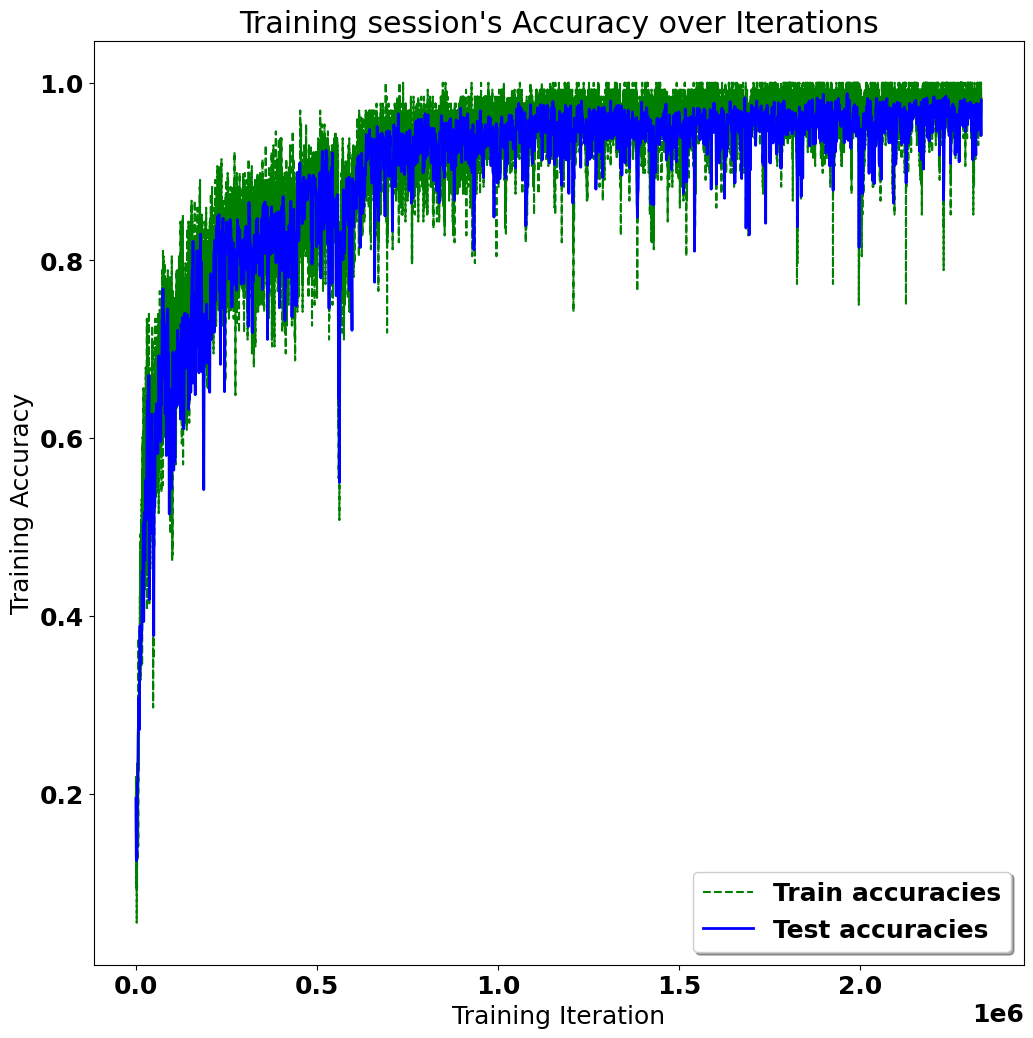

In [10]:

%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
plt.plot(indep_test_axis, np.array(test_accuracies), "b-", linewidth=2.0, label="Test accuracies")
print(len(test_accuracies))
print(len(train_accuracies))

plt.title("Training session's Accuracy over Iterations")
plt.legend(loc='lower right', shadow=True)
plt.ylabel('Training Accuracy')
plt.xlabel('Training Iteration')

plt.show()

# **Confusion Matrix:**

Testing Accuracy: 98.08350205421448%

Precision: 98.1702036258632%
Recall: 98.08350444900753%
f1_score: 98.08323034091224%

Confusion Matrix:
Created using test set of 1461 datapoints


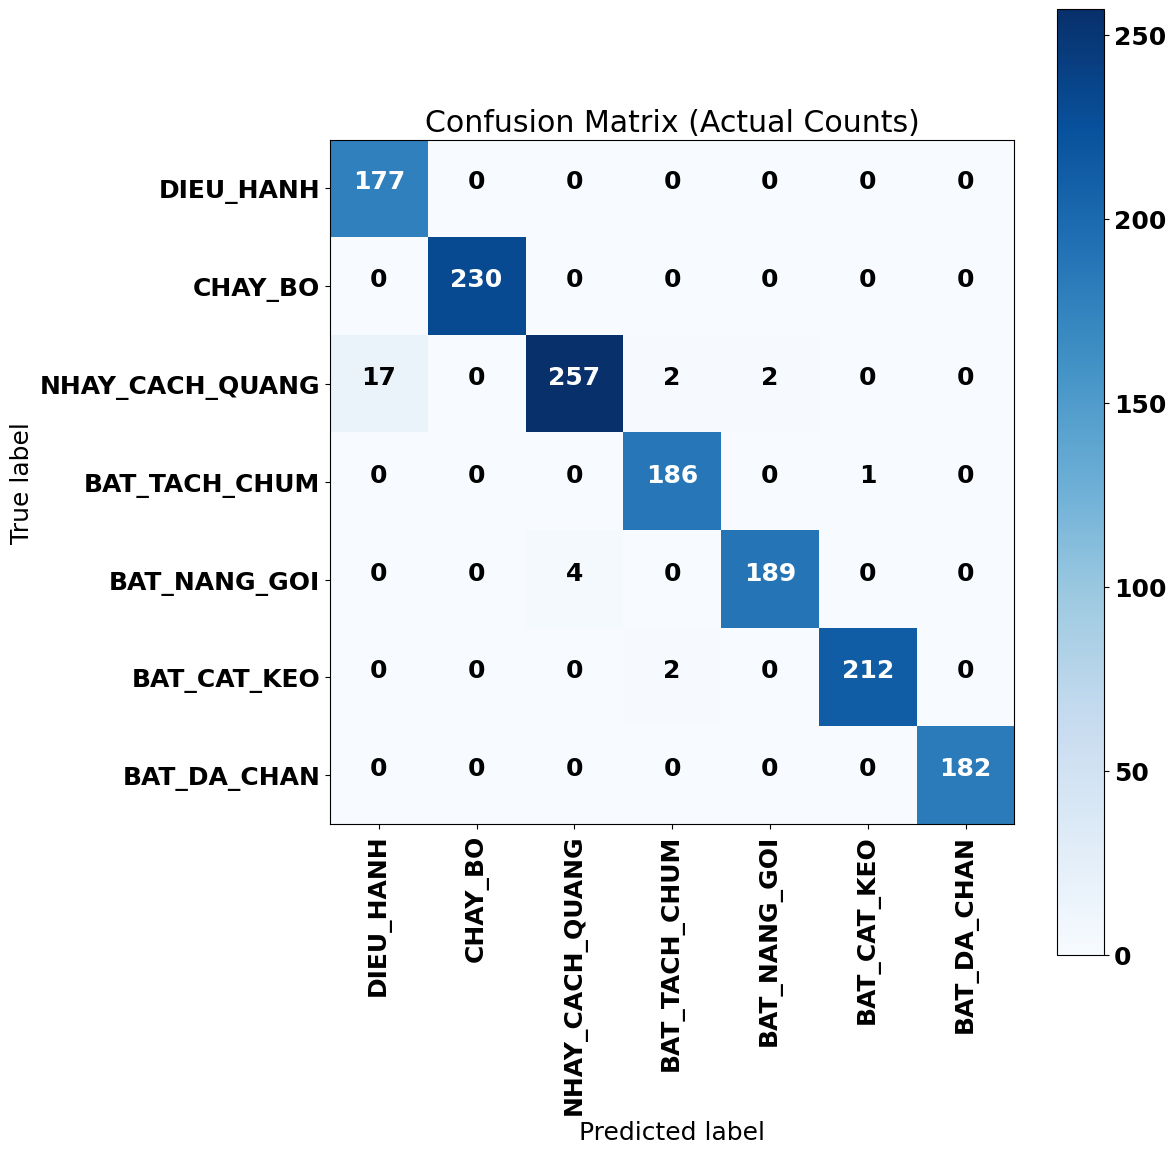

In [11]:

predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
print("Created using test set of {} datapoints".format(len(y_test)))

# Tính confusion matrix (số lượng thực tế)
confusion_matrix = metrics.confusion_matrix(y_test, predictions)

# Vẽ ma trận
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Actual Counts)")
plt.colorbar()

tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)

# Ghi số lượng thực tế vào từng ô
thresh = confusion_matrix.max() / 2.
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        count = confusion_matrix[i, j]
        plt.text(j, i, str(count),
                 horizontalalignment="center",
                 color="white" if count > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

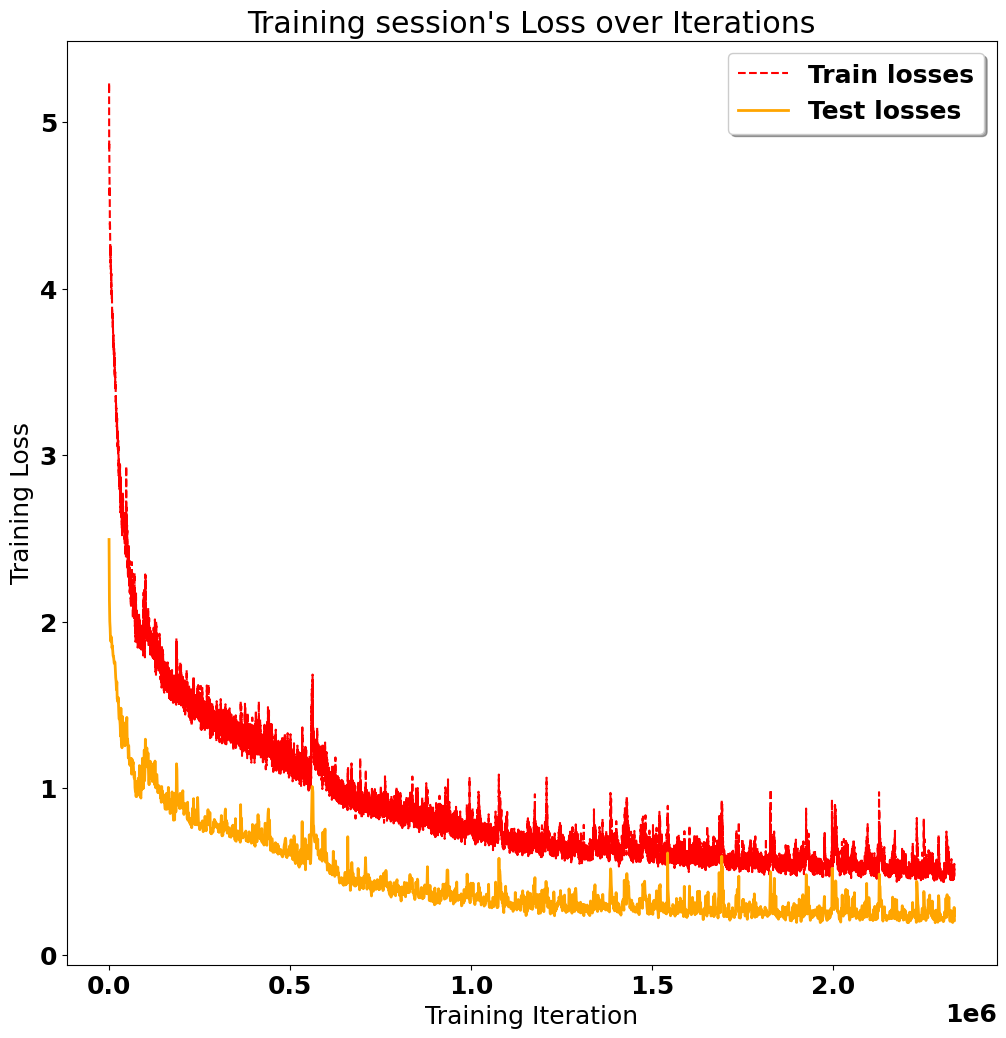

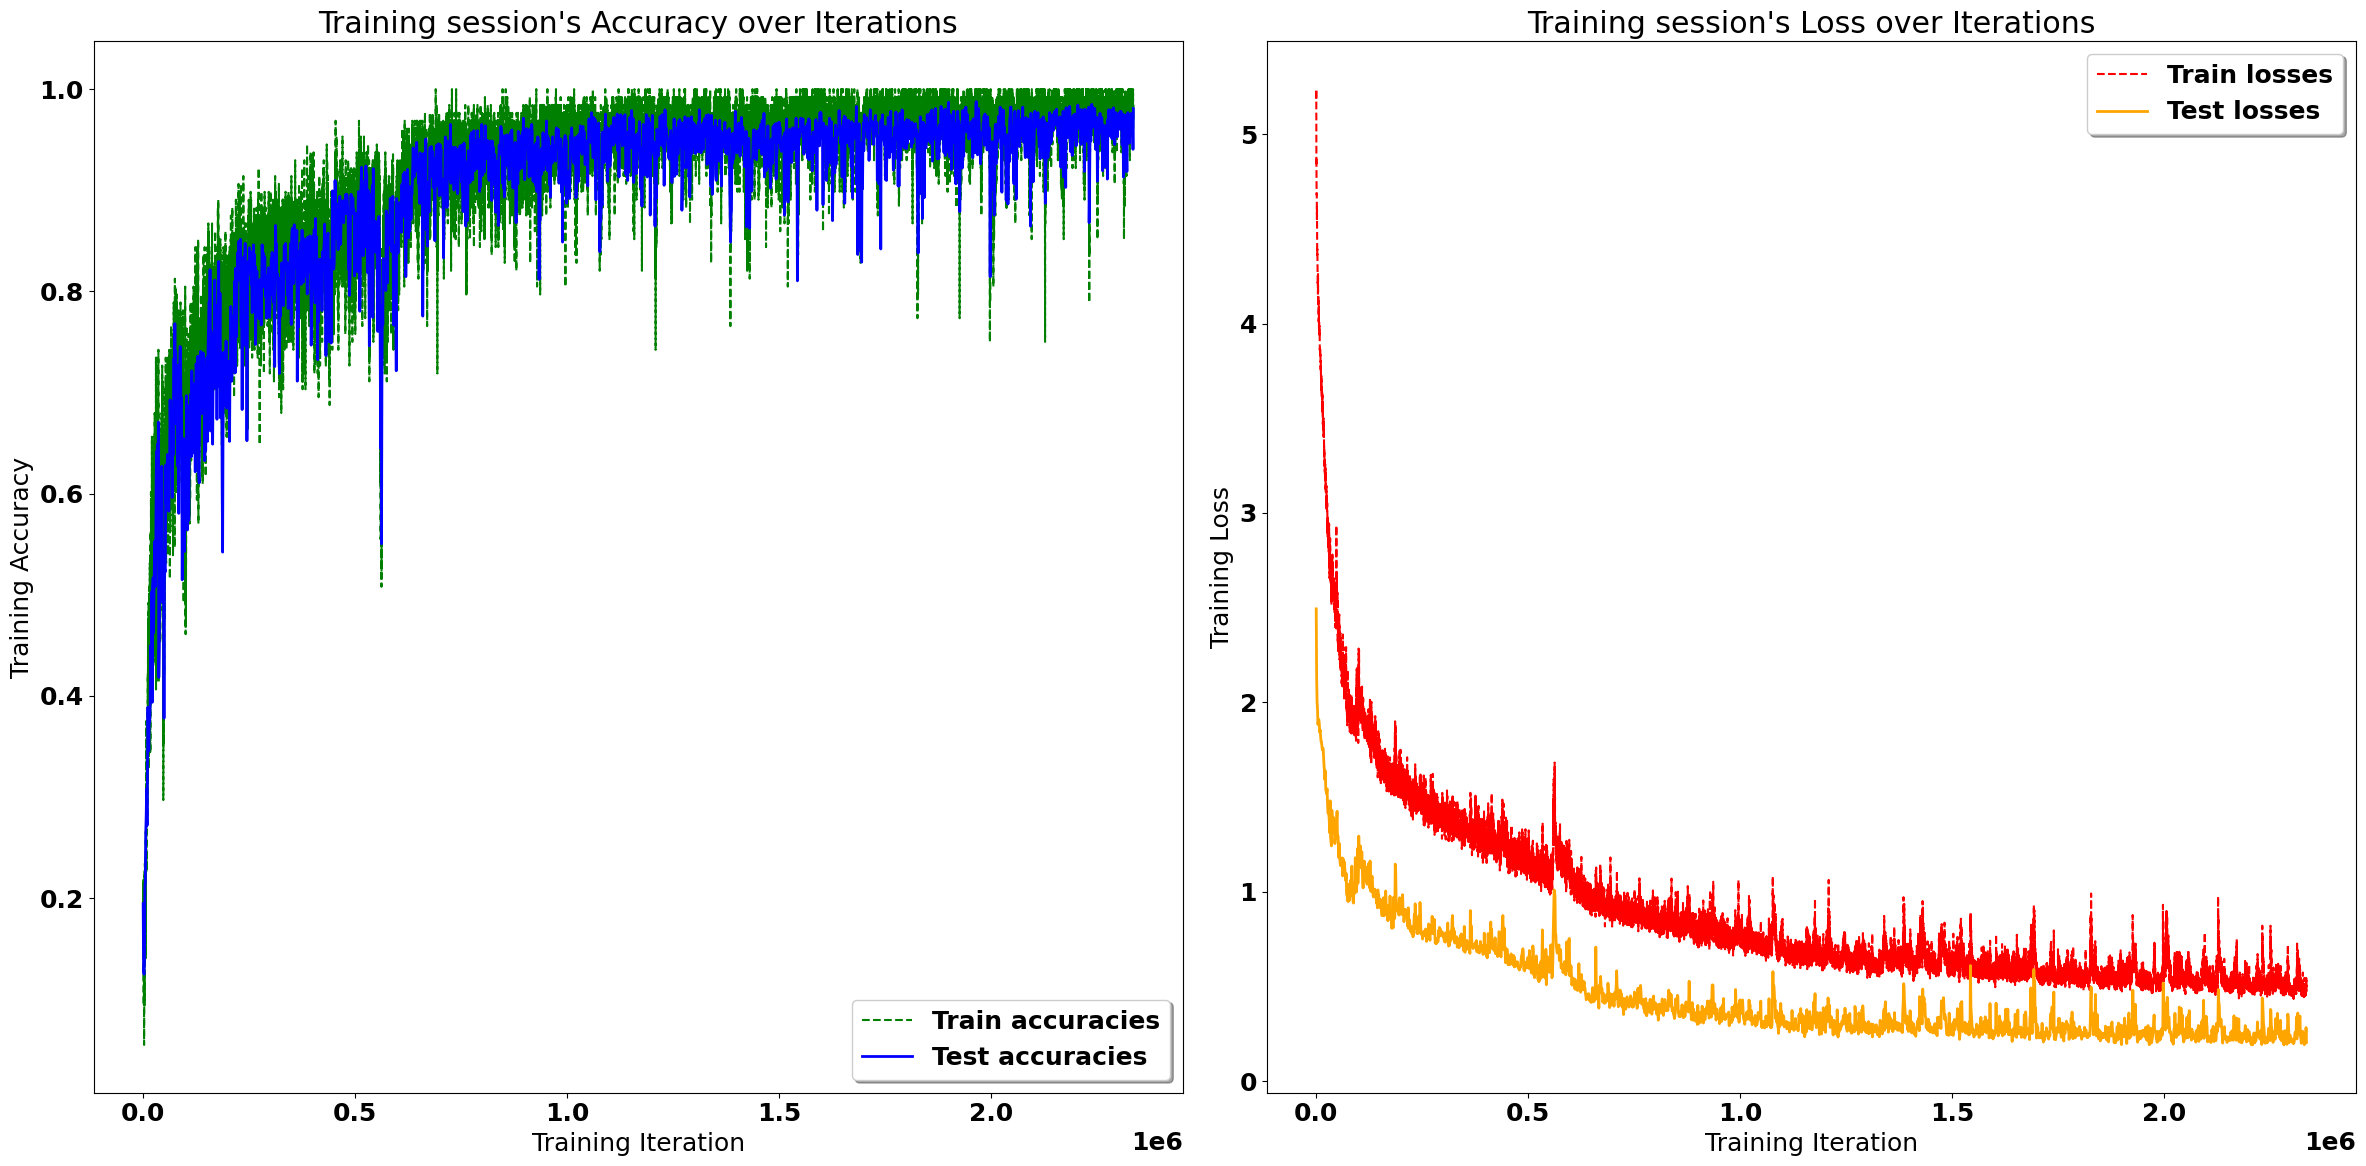


=== TRAINING STATISTICS ===
Final Train Loss: 0.500877
Final Test Loss: 0.203038
Final Train Accuracy: 0.9844
Final Test Accuracy: 0.9808
Best Test Accuracy: 0.9877
Lowest Test Loss: 0.191987


In [12]:

# Vẽ biểu đồ Loss
plt.figure(figsize=(width, height))

# Vẽ training loss
indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses), "r--", label="Train losses")

# Vẽ test loss
indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
plt.plot(indep_test_axis, np.array(test_losses), "orange", linewidth=2.0, label="Test losses")

plt.title("Training session's Loss over Iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Loss')
plt.xlabel('Training Iteration')
plt.show()

# Vẽ cả hai biểu đồ trong cùng một figure (subplot)
plt.figure(figsize=(width*2, height))

# Subplot 1: Accuracy
plt.subplot(1, 2, 1)
indep_train_axis = np.array(range(batch_size, (len(train_accuracies)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_accuracies)*display_iter, display_iter)[:-1]),
    [training_iters]
)
plt.plot(indep_test_axis, np.array(test_accuracies), "b-", linewidth=2.0, label="Test accuracies")

plt.title("Training session's Accuracy over Iterations")
plt.legend(loc='lower right', shadow=True)
plt.ylabel('Training Accuracy')
plt.xlabel('Training Iteration')

# Subplot 2: Loss
plt.subplot(1, 2, 2)
indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses), "r--", label="Train losses")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
plt.plot(indep_test_axis, np.array(test_losses), "orange", linewidth=2.0, label="Test losses")

plt.title("Training session's Loss over Iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Loss')
plt.xlabel('Training Iteration')

plt.tight_layout()
plt.show()

# In thống kê cuối cùng
print("\n=== TRAINING STATISTICS ===")
print(f"Final Train Loss: {train_losses[-1]:.6f}")
print(f"Final Test Loss: {test_losses[-1]:.6f}")
print(f"Final Train Accuracy: {train_accuracies[-1]:.4f}")
print(f"Final Test Accuracy: {test_accuracies[-1]:.4f}")
print(f"Best Test Accuracy: {max(test_accuracies):.4f}")
print(f"Lowest Test Loss: {min(test_losses):.6f}")

In [13]:

# ===== HYPERPARAMETERS SUMMARY =====
print("="*60)
print("                 HYPERPARAMETERS SUMMARY")
print("="*60)

# Model Architecture
print("MODEL ARCHITECTURE:")
print(f"  Input Features (n_input):        {n_input}")
print(f"  Hidden Units (n_hidden):         {n_hidden}")
print(f"  Output Classes (n_classes):      {n_classes}")
print(f"  Time Steps (n_steps):            {n_steps}")
print(f"  LSTM Layers:                     2 layers")
print()

# Training Parameters
epochs = training_iters // training_data_count
print("TRAINING PARAMETERS:")
print(f"  Total Epochs:                    {epochs}")
print(f"  Batch Size:                      {batch_size}")
print(f"  Training Iterations:             {training_iters}")
print(f"  Training Data Count:             {training_data_count}")
print(f"  Test Data Count:                 {test_data_count}")
print(f"  Display Interval:                {display_iter} iterations")
print()

# Optimizer Settings
print("OPTIMIZER:")
print(f"  Type:                            Adam")
print(f"  Decaying Learning Rate:          {decaying_learning_rate}")
if decaying_learning_rate:
    print(f"  Initial Learning Rate:           {init_learning_rate}")
    print(f"  Decay Rate:                      {decay_rate}")
    print(f"  Decay Steps:                     {decay_steps}")
else:
    print(f"  Fixed Learning Rate:             {learning_rate}")
print()

# Regularization
print("REGULARIZATION:")
print(f"  L2 Regularization Lambda:        {lambda_loss_amount}")
print()

# Data Information
print("DATA INFORMATION:")
print(f"  Dataset Path:                    {DATASET_PATH}")
print(f"  Input Shape:                     {X_train.shape}")
print(f"  Labels:                          {LABELS}")
print(f"  Data Mean:                       {np.mean(X_train):.6f}")
print(f"  Data Std:                        {np.std(X_train):.6f}")
print()

# Loss Function
print("LOSS FUNCTION:")
print(f"  Primary Loss:                    Softmax Cross Entropy")
print(f"  Regularization:                  L2 Loss")
print(f"  Total Loss:                      Cross Entropy + L2 Regularization")
print()

# Activation Functions
print("ACTIVATION FUNCTIONS:")
print(f"  Hidden Layer:                    ReLU")
print(f"  LSTM Cells:                      Default (Tanh/Sigmoid)")
print(f"  Output Layer:                    Linear (Softmax for predictions)")
print("="*60)

                 HYPERPARAMETERS SUMMARY
MODEL ARCHITECTURE:
  Input Features (n_input):        36
  Hidden Units (n_hidden):         64
  Output Classes (n_classes):      7
  Time Steps (n_steps):            32
  LSTM Layers:                     2 layers

TRAINING PARAMETERS:
  Total Epochs:                    300
  Batch Size:                      128
  Training Iterations:             2335800
  Training Data Count:             7786
  Test Data Count:                 1461
  Display Interval:                1024 iterations

OPTIMIZER:
  Type:                            Adam
  Decaying Learning Rate:          True
  Initial Learning Rate:           0.005
  Decay Rate:                      0.96
  Decay Steps:                     9000

REGULARIZATION:
  L2 Regularization Lambda:        0.0015

DATA INFORMATION:
  Dataset Path:                    /kaggle/input/data-3-0/
  Input Shape:                     (7786, 32, 36)
  Labels:                          ['DIEU_HANH', 'CHAY_BO', 'NHAY_CACH